In [16]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
import shutil

cudnn.benchmark = True
plt.ion()   # interactive mode

In [17]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.RandomResizedCrop(480),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        transforms.Resize(480),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [18]:
train_json = pd.read_json('./data/amap_traffic_annotations_train.json')
train_json.head()

,annotations
0,"{'id': '000001', 'key_frame': '3.jpg', 'status..."
1,"{'id': '000002', 'key_frame': '4.jpg', 'status..."
2,"{'id': '000003', 'key_frame': '5.jpg', 'status..."
3,"{'id': '000004', 'key_frame': '3.jpg', 'status..."
4,"{'id': '000005', 'key_frame': '5.jpg', 'status..."


In [19]:
train_json = train_json['annotations']
train_json

0       {'id': '000001', 'key_frame': '3.jpg', 'status...
1       {'id': '000002', 'key_frame': '4.jpg', 'status...
2       {'id': '000003', 'key_frame': '5.jpg', 'status...
3       {'id': '000004', 'key_frame': '3.jpg', 'status...
4       {'id': '000005', 'key_frame': '5.jpg', 'status...
                              ...                        
1495    {'id': '001496', 'key_frame': '3.jpg', 'status...
1496    {'id': '001497', 'key_frame': '4.jpg', 'status...
1497    {'id': '001498', 'key_frame': '3.jpg', 'status...
1498    {'id': '001499', 'key_frame': '5.jpg', 'status...
1499    {'id': '001500', 'key_frame': '3.jpg', 'status...
Name: annotations, Length: 1500, dtype: object

In [20]:
new_path = './data/amap_frames/'
old_path = './data/amap_traffic_train_0712/'

In [21]:
def build_data_folder(main_json, old_path, new_path, phase):
    root_path = new_path+phase
    # if not os.path.exists(root_path):
    # os.makedirs(root_path)
    for item in main_json:
        map_id = item['id']
        key_frame_name = item['key_frame']
        temp_path = root_path + '/' + str(item['status']) + '/'
        if not os.path.exists(temp_path):
            os.makedirs(temp_path)
        shutil.copy(old_path+map_id+'/'+key_frame_name, temp_path+map_id+'_'+key_frame_name)

In [22]:
# build_data_folder(train_json, old_path, new_path, 'train')

In [23]:
data_dir = './data/amap_frames/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        # for phase in ['train', 'val']:
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

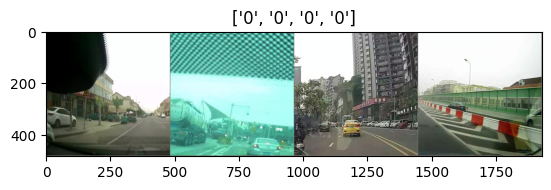

In [25]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [27]:
model_conv = torchvision.models.resnext101_32x8d()
temp_weights = torch.load('./model/ig_resnext101_32x8-c38310e5.pth')
model_conv.load_state_dict(temp_weights)

<All keys matched successfully>

In [28]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 1024), 
                              nn.ReLU(), nn.Linear(1024, 256), 
                              nn.ReLU(), nn.Linear(256, 3))

model_conv = model_conv.to(device)

In [29]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.7266 Acc: 0.7273

Epoch 1/49
----------
train Loss: 0.6788 Acc: 0.7500

Epoch 2/49
----------
train Loss: 0.6790 Acc: 0.7467

Epoch 3/49
----------
train Loss: 0.6370 Acc: 0.7607

Epoch 4/49
----------
train Loss: 0.6348 Acc: 0.7627

Epoch 5/49
----------
train Loss: 0.6365 Acc: 0.7613

Epoch 6/49
----------
train Loss: 0.6438 Acc: 0.7620

Epoch 7/49
----------
train Loss: 0.6047 Acc: 0.7727

Epoch 8/49
----------
train Loss: 0.6061 Acc: 0.7700

Epoch 9/49
----------
train Loss: 0.5960 Acc: 0.7853

Epoch 10/49
----------
train Loss: 0.5919 Acc: 0.7793

Epoch 11/49
----------
train Loss: 0.5864 Acc: 0.7840

Epoch 12/49
----------
train Loss: 0.5978 Acc: 0.7747

Epoch 13/49
----------
train Loss: 0.5834 Acc: 0.7880

Epoch 14/49
----------
train Loss: 0.6062 Acc: 0.7687

Epoch 15/49
----------
train Loss: 0.5845 Acc: 0.7707

Epoch 16/49
----------
train Loss: 0.5859 Acc: 0.7833

Epoch 17/49
----------
train Loss: 0.5901 Acc: 0.7787

Epoch 18/49
--------

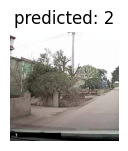

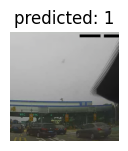

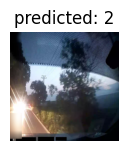

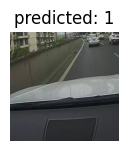

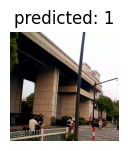

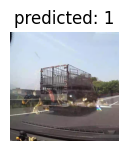

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [32]:
torch.save(model_conv.state_dict(), './model/resnext/1.pth')

In [33]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 3)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)
# torch.save(model_ft.state_dict(), './model/resnext/1.pth')
# visualize_model(model_ft)